# Model Training

## Imports

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

## Loading best result grid search

In [4]:
df = pd.read_csv("/kaggle/input/image-size-gridsearch-result/image_size_gridsearch_result.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.sort_values("test_accuracy", ascending=False)
df.head()

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


Class_weight is overgenomen uit notebook 4

In [5]:
best_result = df.iloc[0]
width = best_result["width"]
height = best_result["height"]
statistic = best_result["statistic"]
interpolation = best_result["interpolation"]
painters = ["Mondriaan", "Picasso"]
base_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
class_weight = {0: 2.8156565656565657, 1: 0.6079607415485279}

## Helper functions

In [6]:
def build_model(width, height, data_augmentation=None):
    model_layers = [
        layers.InputLayer(shape=(width, height, 3)),
    ]
    if data_augmentation:
        model_layers.append(data_augmentation)
    
    model_layers.extend([
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    model = keras.Sequential(model_layers)
    return model

model = build_model(width, height)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 603, 647, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 601, 645, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 300, 322, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 298, 320, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 149, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 147, 158, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 73, 79, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 71, 77, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 35, 38, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 33, 36, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         304,129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,282,625 (4.89 MB)

 Trainable params: 1,282,625 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [8]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

train, val, test = load_dataset(base_dir, painters, width, height, interpolation=interpolation)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


In [9]:
def print_classifiction_report(model, test_dataset):
    y_pred = model.predict(test_dataset)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    print(classification_report(y_true, y_pred, zero_division=0))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        cmap='Blues'
    )
    plt.title('Confusion Matrix')
    plt.show()

## Model training

### Model listing 8.7

In [10]:
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7.keras",
save_best_only=True,
monitor="val_loss")
]


history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 310ms/step - accuracy: 0.4488 - loss: 2.0028 - val_accuracy: 0.8221 - val_loss: 0.4664
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5885 - loss: 0.7680 - val_accuracy: 0.7439 - val_loss: 0.6664
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5674 - loss: 0.7340 - val_accuracy: 0.7790 - val_loss: 0.6451
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6625 - loss: 0.6750 - val_accuracy: 0.6712 - val_loss: 0.5231
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6269 - loss: 0.7697 - val_accuracy: 0.5148 - val_loss: 0.6523
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6039 - loss: 0.7083 - val_accuracy: 0.6900 - val_loss: 0.5928
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6782 - loss: 0.7173 - val_accuracy: 0.6065 - val_loss: 0.8673
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.7010 - loss: 0.6277 - val_accuracy: 0

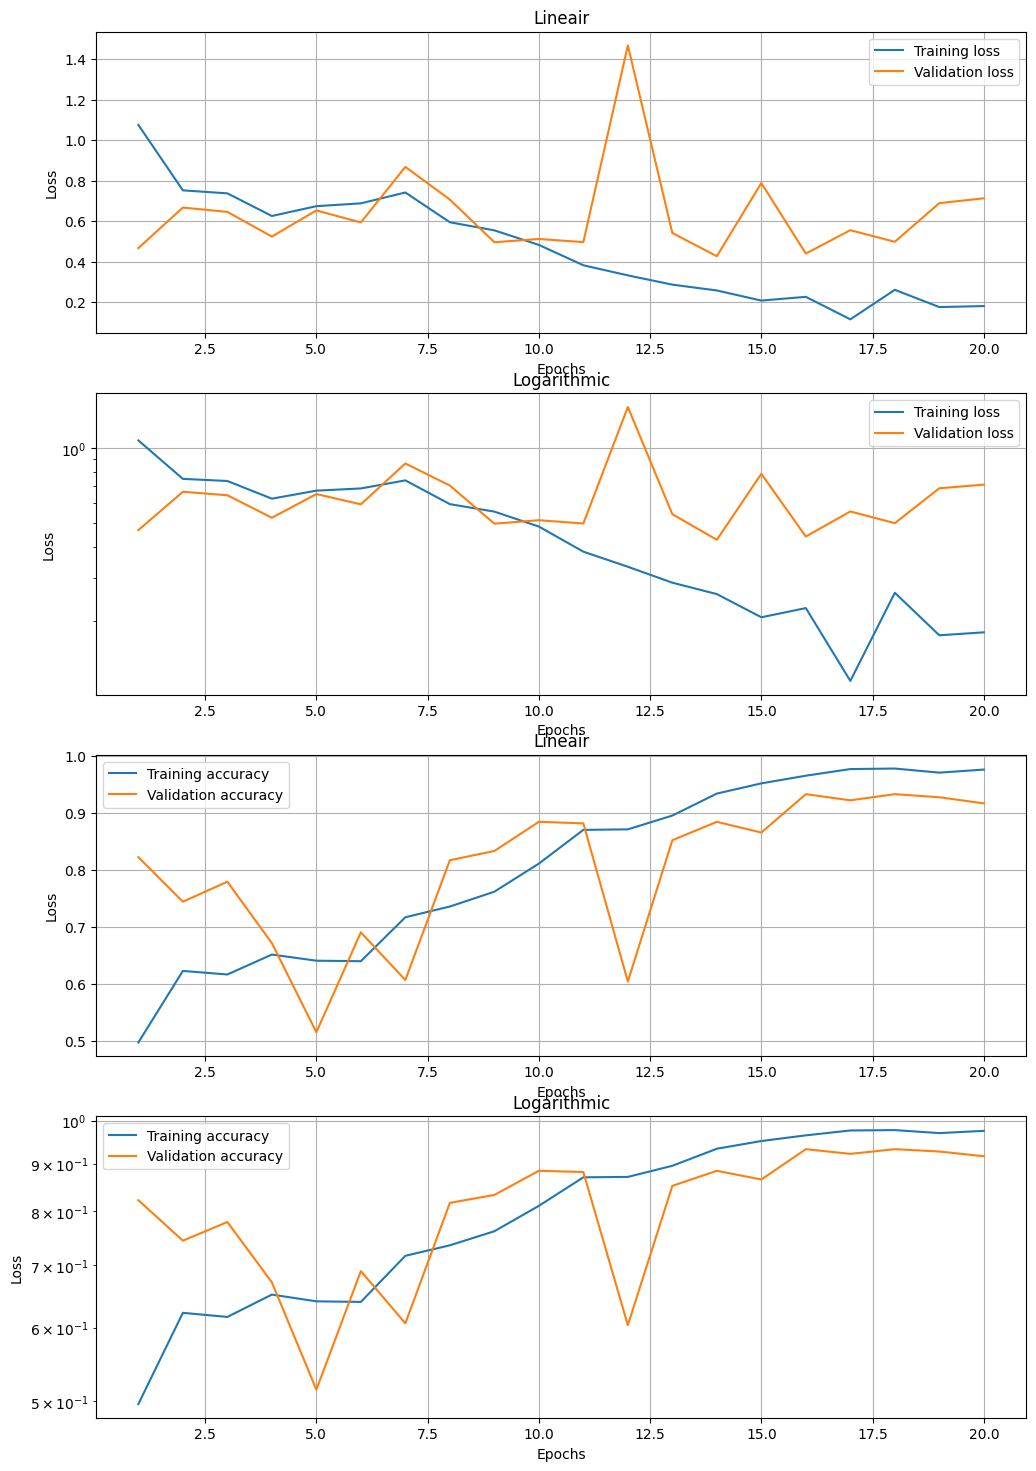

In [11]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
              precision    recall  f1-score   support

           0       0.21      0.20      0.20        66
           1       0.83      0.84      0.84       305

    accuracy                           0.73       371
   macro avg       0.52      0.52      0.52       371
weighted avg       0.72      0.73      0.72       371



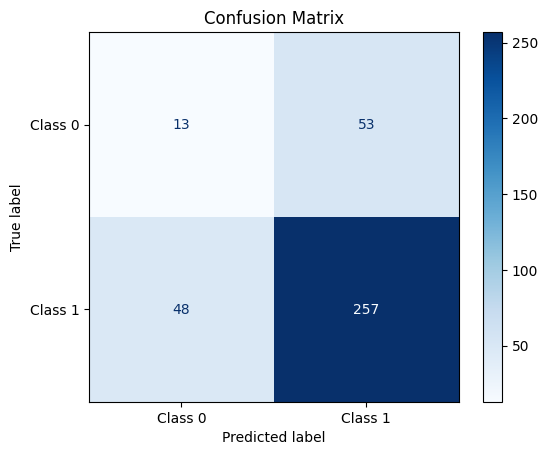

In [12]:
print_classifiction_report(model, test)

### Model listing 8.7 met data augmentation 8.14

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.4812 - loss: 2.0998 - val_accuracy: 0.8194 - val_loss: 0.5909
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6080 - loss: 0.7251 - val_accuracy: 0.3288 - val_loss: 0.6956
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6313 - loss: 0.6730 - val_accuracy: 0.7143 - val_loss: 0.6038
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6655 - loss: 0.6814 - val_accuracy: 0.7574 - val_loss: 0.5347
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6540 - loss: 0.6586 - val_accuracy: 0.2372 - val_loss: 1.3032
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.6090 - loss: 0.6571 - val_accuracy: 0.6361 - val_loss: 0.6018
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.7068 - loss: 0.5963 - val_accuracy: 0.8571 - val_loss: 0.3541
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.7853 - loss: 0.4860 - val_accuracy: 0

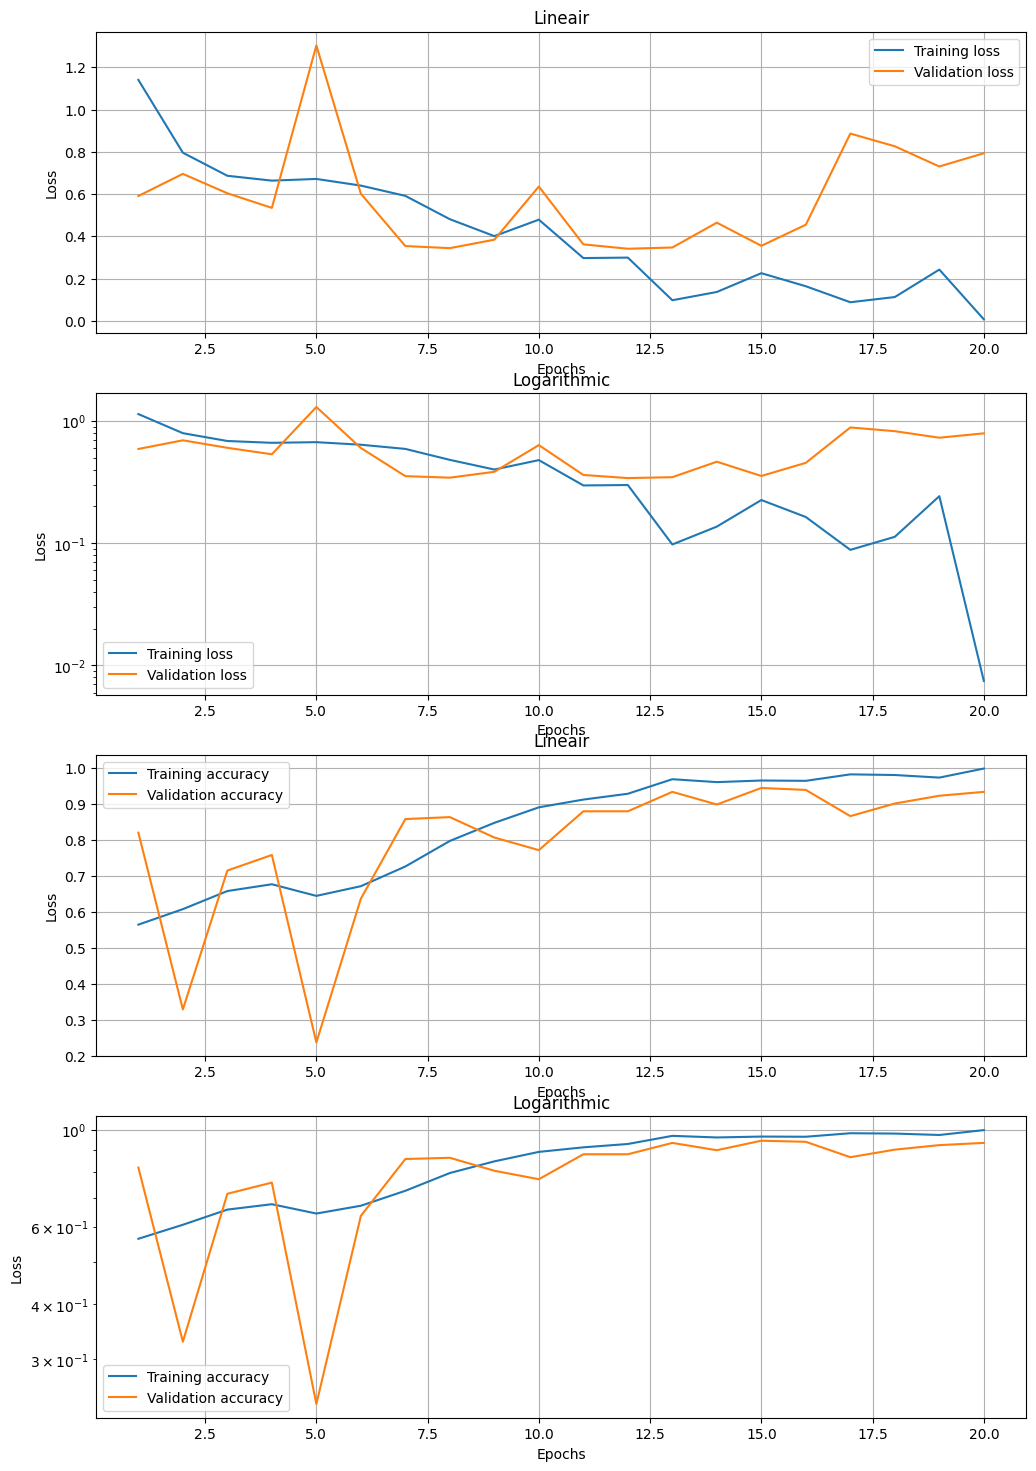

In [14]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
              precision    recall  f1-score   support

           0       0.07      0.08      0.07        66
           1       0.80      0.78      0.79       305

    accuracy                           0.65       371
   macro avg       0.43      0.43      0.43       371
weighted avg       0.67      0.65      0.66       371



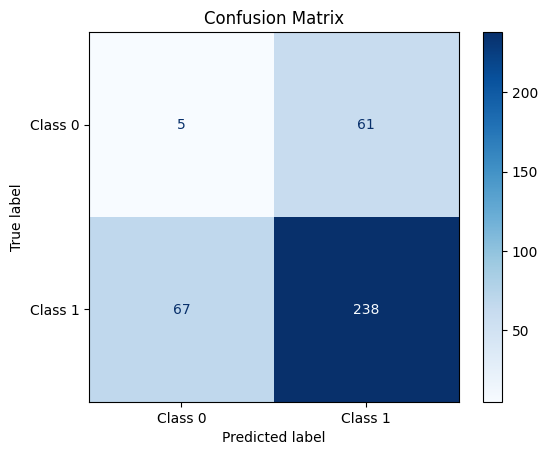

In [15]:
print_classifiction_report(model, test)

### Model listing 8.16

In [17]:
inputs = keras.Input(shape=(width, height, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.16.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=30, validation_data=val, class_weight=class_weight)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.5028 - loss: 1.1894 - val_accuracy: 0.6146 - val_loss: 0.6726
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.6373 - loss: 0.7231 - val_accuracy: 0.8005 - val_loss: 0.5161
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.6307 - loss: 0.7213 - val_accuracy: 0.3666 - val_loss: 1.1260
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6163 - loss: 0.6549 - val_accuracy: 0.6658 - val_loss: 0.5939
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6604 - loss: 0.6572 - val_accuracy: 0.8113 - val_loss: 0.4291
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.6784 - loss: 0.6690 - val_accuracy: 0.8221 - val_loss: 0.6127
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.7248 - loss: 0.7183 - val_accuracy: 0.8194 - val_loss: 0.4406
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7322 - loss: 0.6159 - val_accu

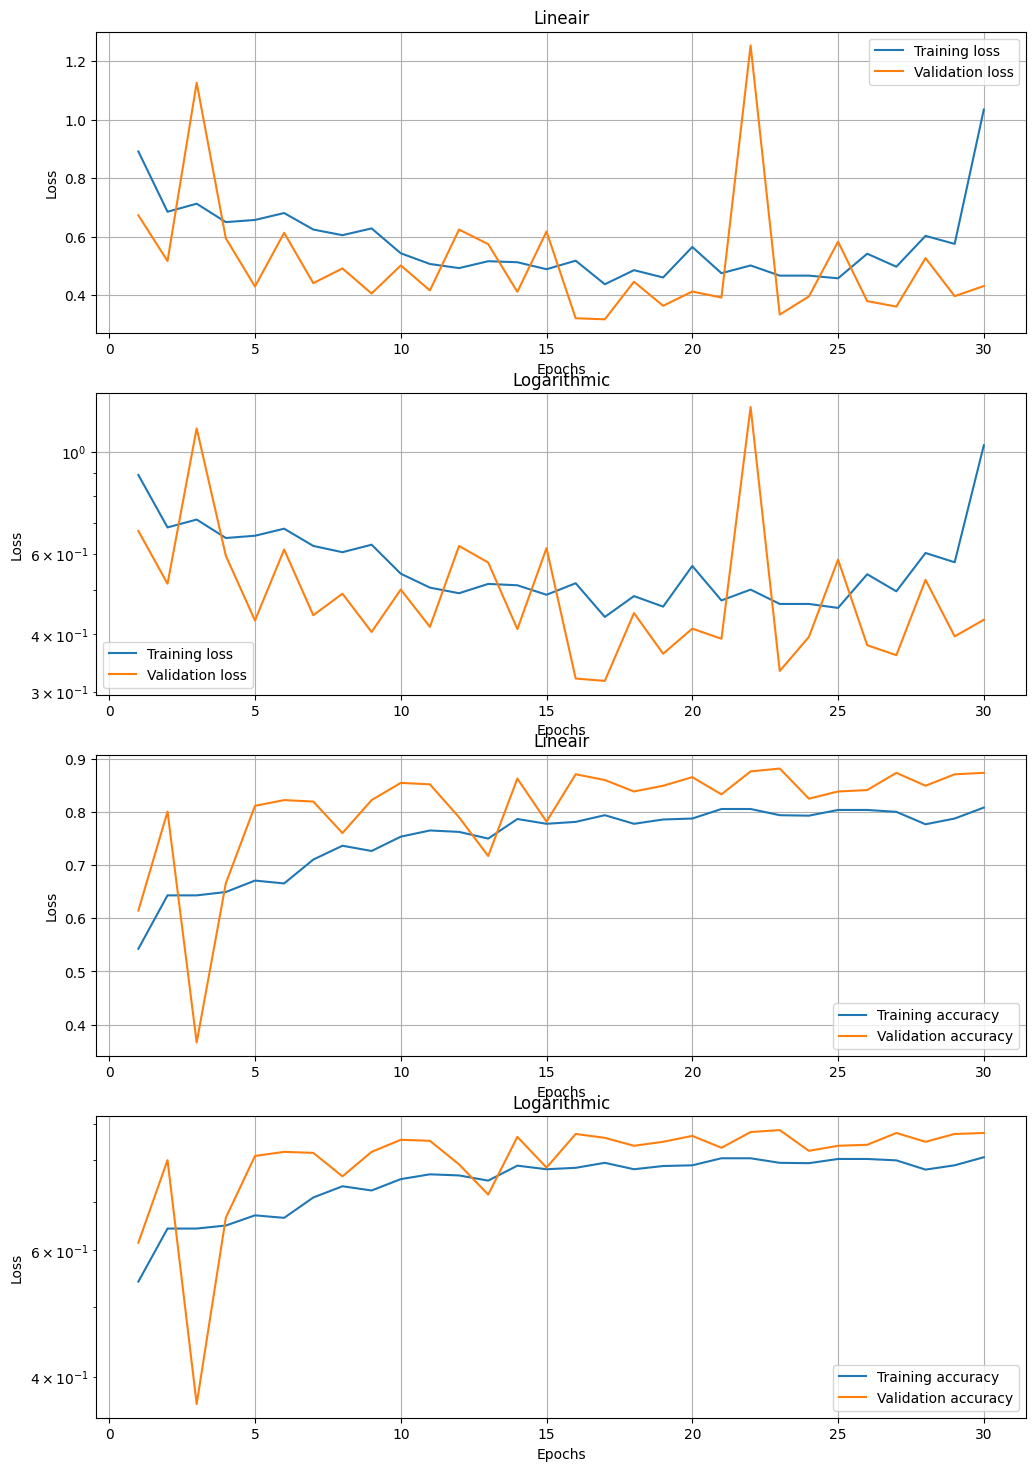

In [18]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

           0       0.17      0.08      0.10        66
           1       0.82      0.92      0.87       305

    accuracy                           0.77       371
   macro avg       0.49      0.50      0.49       371
weighted avg       0.70      0.77      0.73       371



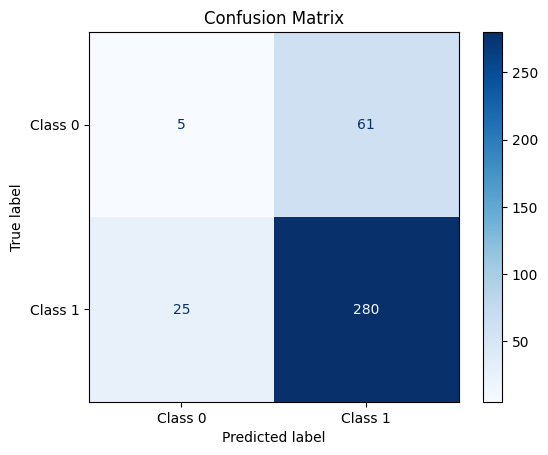

In [19]:
print_classifiction_report(model, test)

### Feature extraction met VGG16

In [20]:
def print_classification_report_and_confusion_matrix(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    y_pred = np.where(y_pred > 0.5, 1, 0)  
    y_true = test_labels

    print(classification_report(y_true, y_pred, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1']
    )
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 603, 647, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 603, 647, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 603, 647, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 301, 323, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 301, 323, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 301, 323, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 150, 161, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 150, 161, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 150, 161, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 150, 161, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 75, 80, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 75, 80, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 75, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 75, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 37, 40, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 18, 20, 512)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(val)
test_features, test_labels = get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [23]:
train_features.shape

(1115, 18, 20, 512)

In [24]:
input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [25]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]
history = model.fit(train_features, train_labels,epochs=20,validation_data=(val_features, val_labels),
callbacks=callbacks, class_weight=class_weight)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7769 - loss: 851.9091 - val_accuracy: 0.8760 - val_loss: 136.6516
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9209 - loss: 132.3196 - val_accuracy: 0.7439 - val_loss: 423.7981
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9444 - loss: 60.9974 - val_accuracy: 0.9461 - val_loss: 69.5788
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9912 - loss: 7.5830 - val_accuracy: 0.9434 - val_loss: 73.6168
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9920 - loss: 2.1996 - val_accuracy: 0.9488 - val_loss: 78.9512
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9916 - loss: 13.9938 - val_accuracy: 0.9326 - val_loss: 82.3729
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9937 - loss: 8.0521 - val_accuracy: 0.9245 - val_loss: 118.0318
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9902 - loss: 4.2759 - val_acc

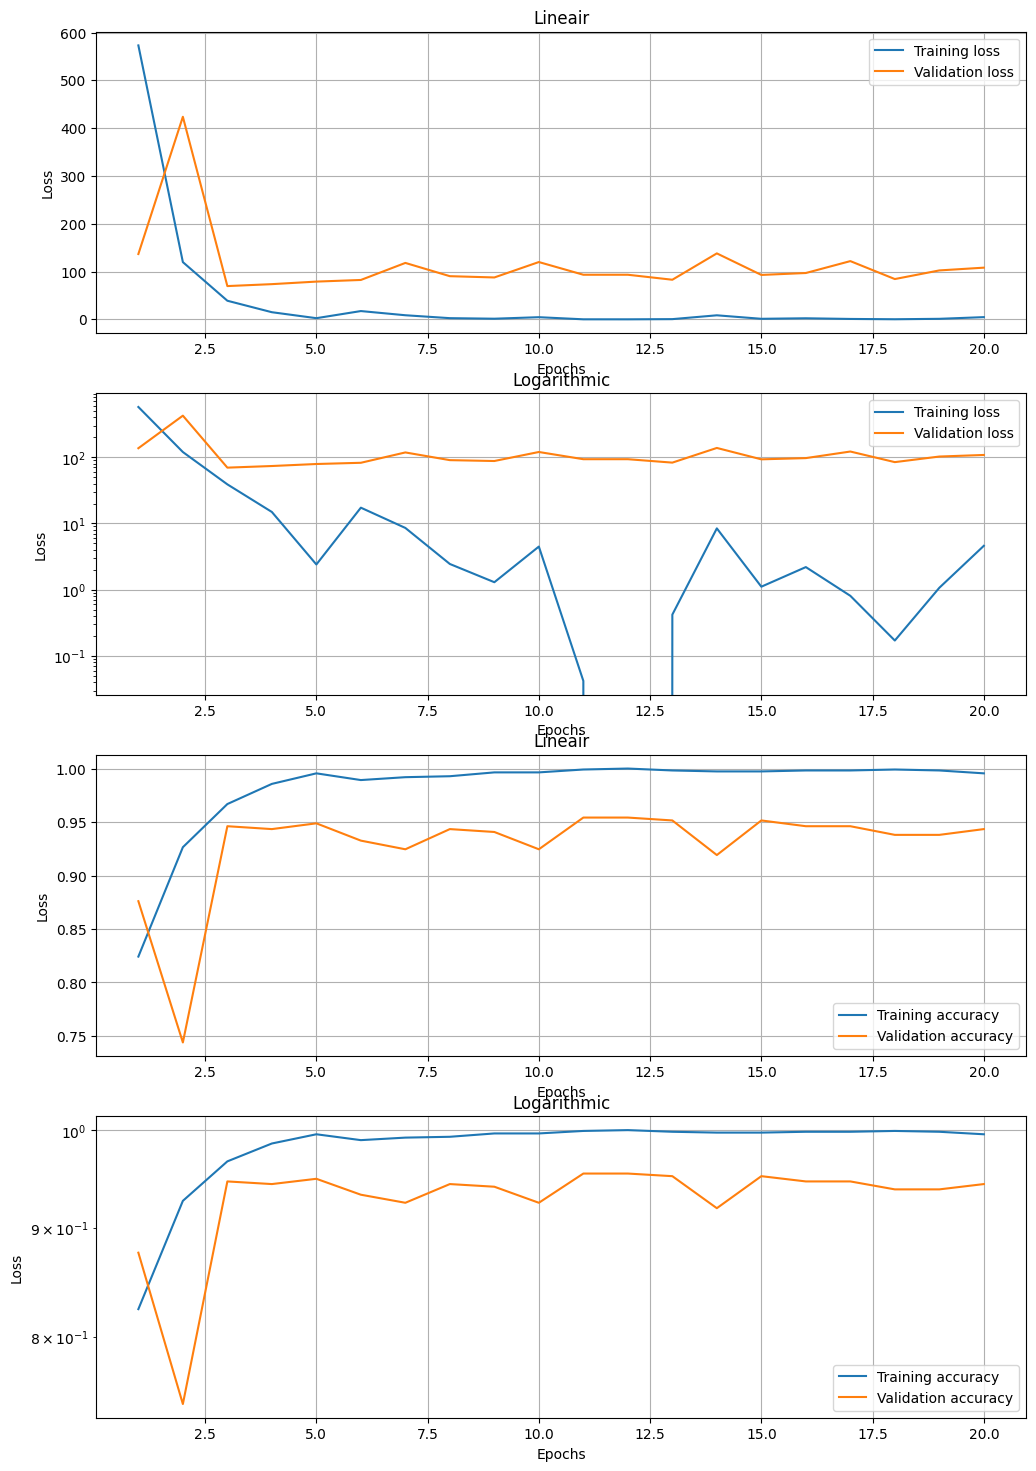

In [26]:
plot_loss(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        66
           1       0.98      0.98      0.98       305

    accuracy                           0.97       371
   macro avg       0.94      0.94      0.94       371
weighted avg       0.97      0.97      0.97       371



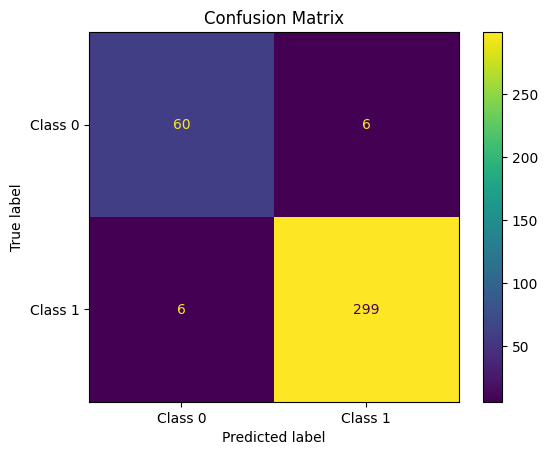

In [27]:
print_classification_report_and_confusion_matrix(model, test_features, test_labels)

### Uitbreiding met data augmentation

In [28]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
conv_base.trainable = False

In [29]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
    ]
history = model.fit(
train,
epochs=20,
validation_data=val,
callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 558ms/step - accuracy: 0.7918 - loss: 276.1355 - val_accuracy: 0.8976 - val_loss: 66.8927
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step - accuracy: 0.9281 - loss: 39.4909 - val_accuracy: 0.9299 - val_loss: 46.3418
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9370 - loss: 40.0428 - val_accuracy: 0.9084 - val_loss: 62.7673
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9513 - loss: 22.2524 - val_accuracy: 0.9299 - val_loss: 77.8251
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9620 - loss: 28.3145 - val_accuracy: 0.9057 - val_loss: 127.0829
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - accuracy: 0.9762 - loss: 11.8200 - val_accuracy: 0.9218 - val_loss: 81.0296
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9730 - loss: 12.1572 - val_accuracy: 0.9434 - val_loss: 57.1399
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9733 - loss: 8

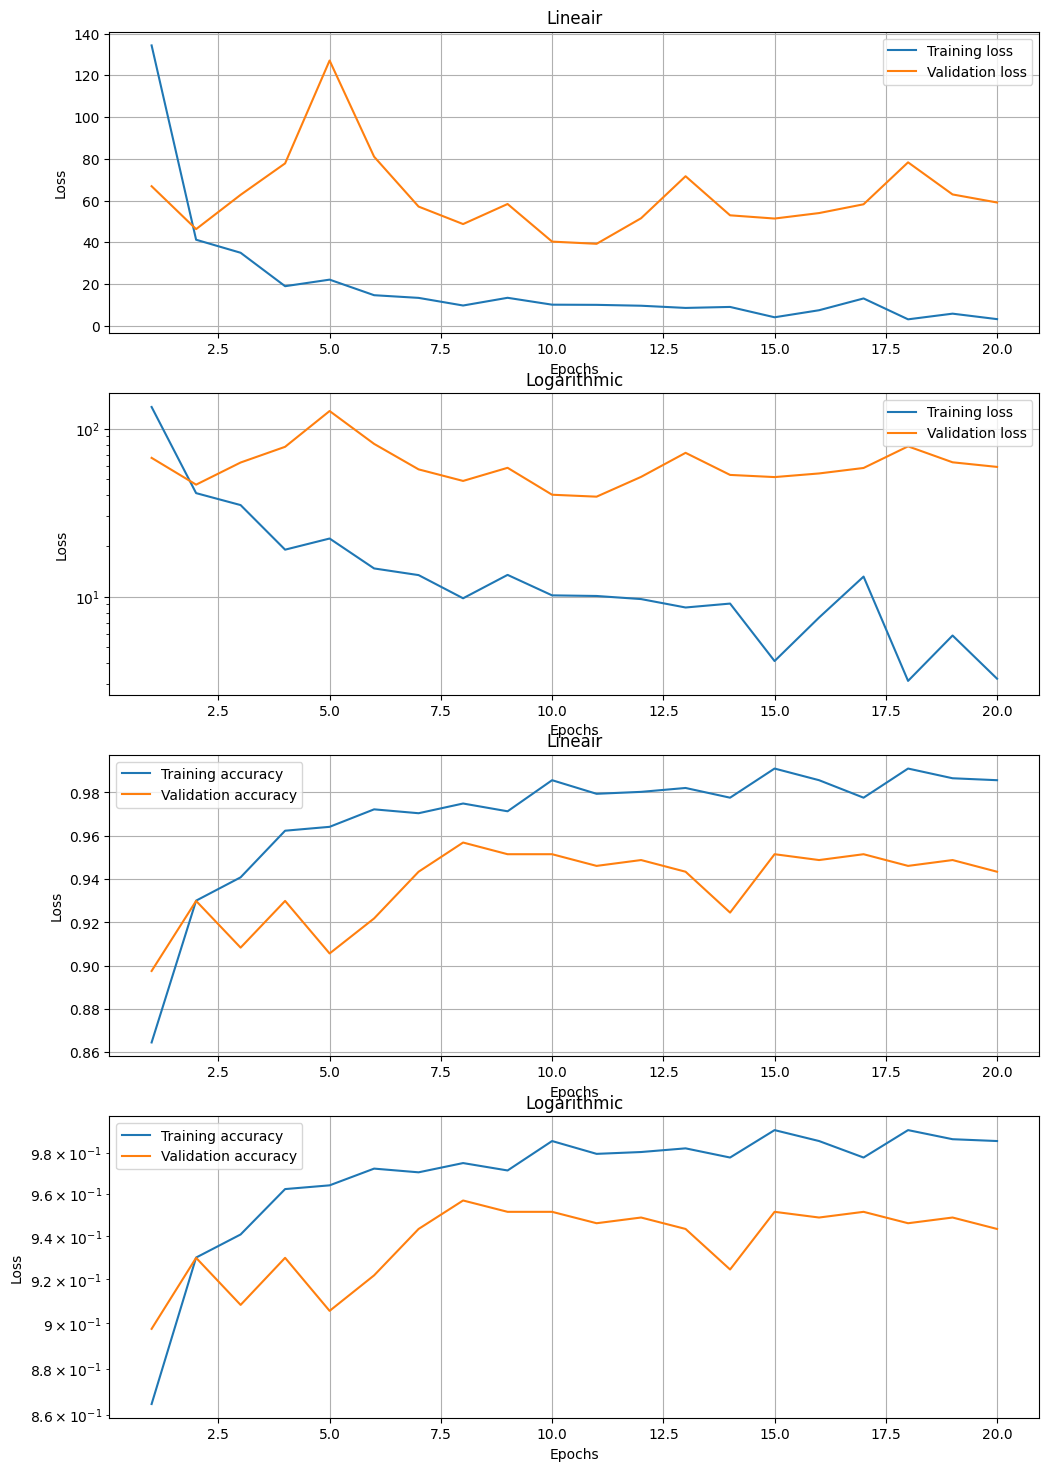

In [31]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step
              precision    recall  f1-score   support

           0       0.19      0.20      0.19        66
           1       0.82      0.82      0.82       305

    accuracy                           0.71       371
   macro avg       0.51      0.51      0.51       371
weighted avg       0.71      0.71      0.71       371



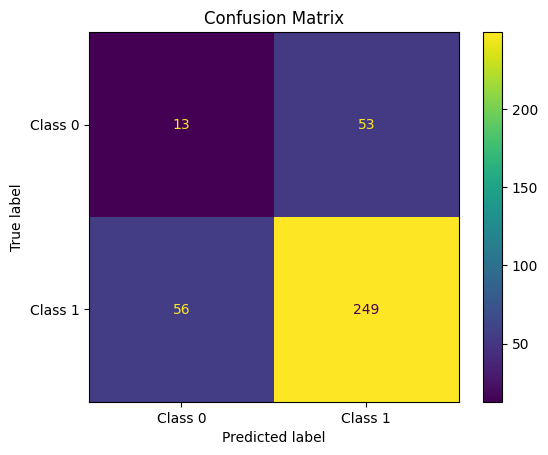

In [32]:
print_classification_report_and_confusion_matrix(model, test, test_labels)

### Finetuning van VGG16 conv base

In [33]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [35]:
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")]
history = model.fit(train,epochs=30,validation_data=val,callbacks=callbacks, class_weight=class_weight)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 485ms/step - accuracy: 0.9935 - loss: 1.4030 - val_accuracy: 0.9596 - val_loss: 29.5844
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 482ms/step - accuracy: 0.9951 - loss: 2.2908 - val_accuracy: 0.9461 - val_loss: 26.4249
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 482ms/step - accuracy: 0.9972 - loss: 0.3493 - val_accuracy: 0.9623 - val_loss: 23.9989
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 442ms/step - accuracy: 0.9941 - loss: 0.8579 - val_accuracy: 0.9623 - val_loss: 27.0986
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - accuracy: 0.9968 - loss: 0.6453 - val_accuracy: 0.9542 - val_loss: 24.2806
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - accuracy: 0.9901 - loss: 0.8598 - val_accuracy: 0.9353 - val_loss: 28.0562
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - accuracy: 0.9924 - loss: 1.1395 - val_accuracy: 0.9542 - val_loss: 29.6647
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 481ms/step - accuracy: 0.9959 - loss: 0.7722 - v

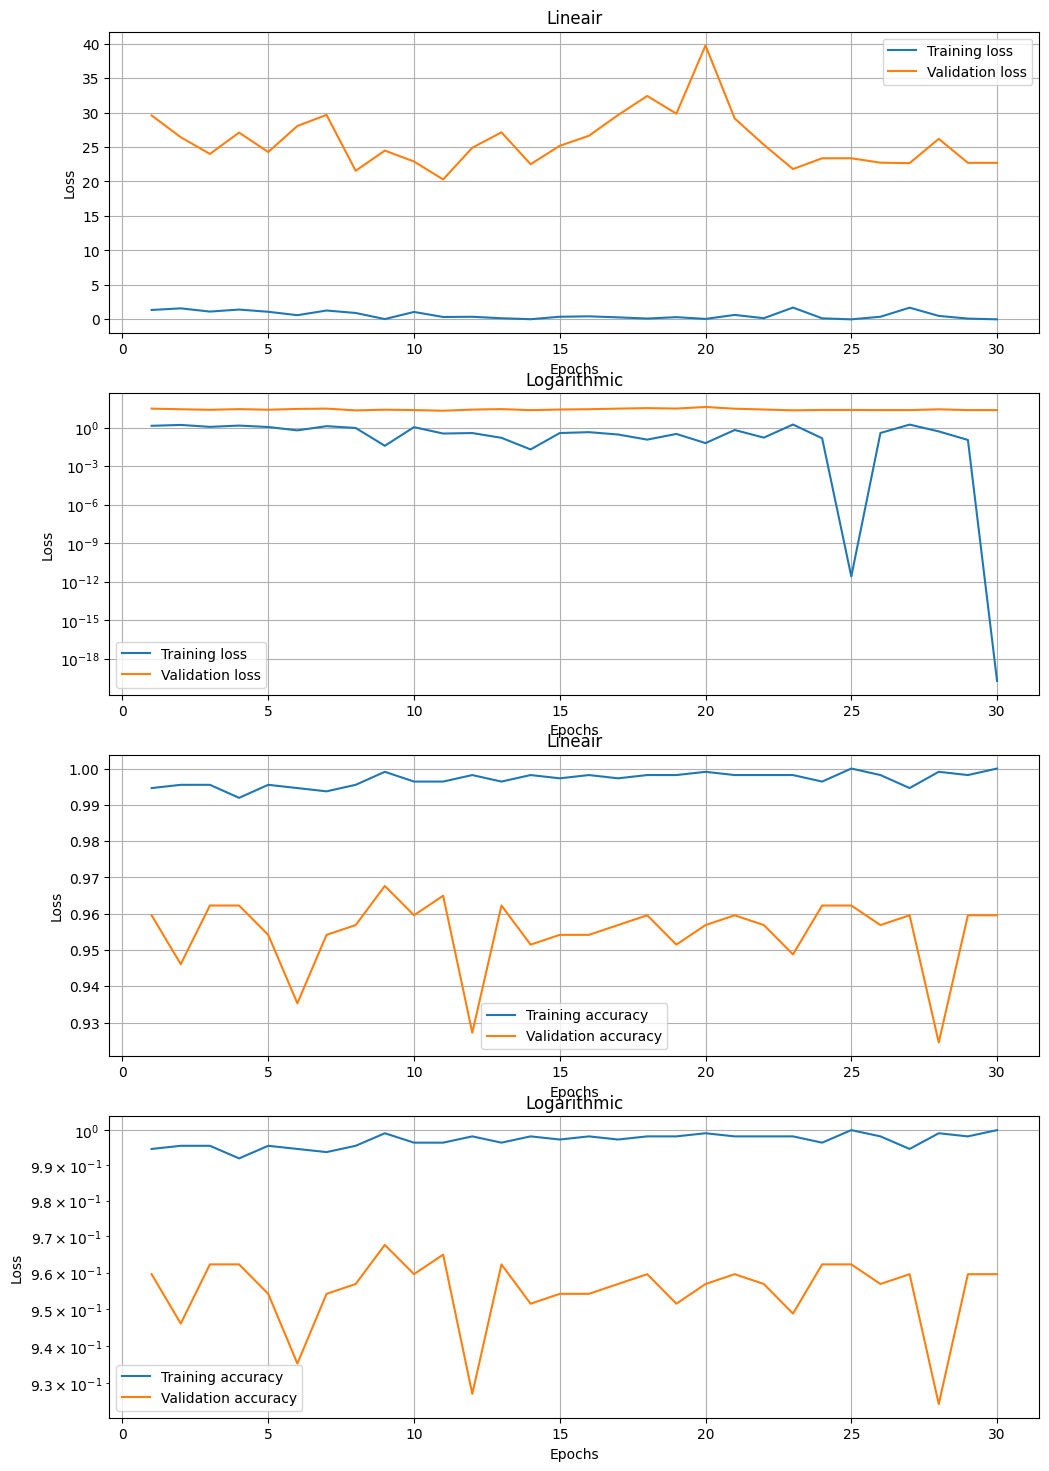

In [36]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step
              precision    recall  f1-score   support

           0       0.25      0.23      0.24        66
           1       0.84      0.85      0.84       305

    accuracy                           0.74       371
   macro avg       0.54      0.54      0.54       371
weighted avg       0.73      0.74      0.74       371



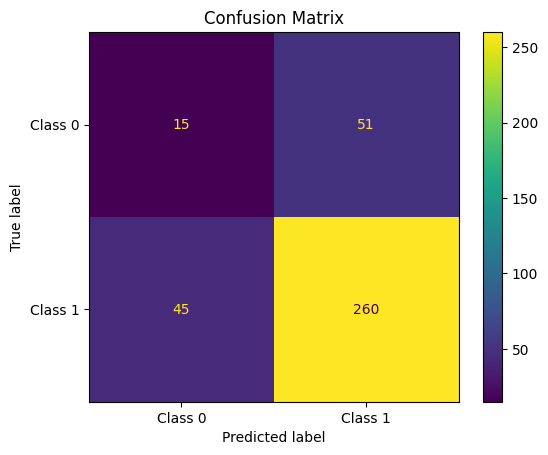

In [37]:
print_classification_report_and_confusion_matrix(model, test, test_labels)

### Xception

In [38]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 603, 647, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 301, 323, 32)   │            864 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 301, 323, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 301, 323, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 299, 321, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 299, 321, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 299, 321, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 299, 321, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 299, 321, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 299, 321, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 299, 321, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 299, 321, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 150, 161, 128)  │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 150, 161, 128)  │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [42]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # Preprocess input using Xception's preprocessing function
        images = tf.cast(images, tf.float32)
        preprocessed_images = keras.applications.xception.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels from training, validation, and test datasets
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(val)
test_features, test_labels = get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104

In [44]:
input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [45]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_xception.keras",
        save_best_only=True,
        monitor="val_loss")]

history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 571ms/step - accuracy: 0.7449 - loss: 47.0741 - val_accuracy: 0.9650 - val_loss: 0.5854
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.9533 - loss: 1.0011 - val_accuracy: 0.9596 - val_loss: 0.4164
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 364ms/step - accuracy: 0.9694 - loss: 0.4641 - val_accuracy: 0.9757 - val_loss: 0.2628
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9758 - loss: 0.3475 - val_accuracy: 0.9704 - val_loss: 0.3298
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.9913 - loss: 0.0818 - val_accuracy: 0.9569 - val_loss: 0.2579
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.9794 - loss: 0.1549 - val_accuracy: 0.9838 - val_loss: 0.1826
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.9923 - loss: 0.0717 - val_accuracy: 0.9811 - val_loss: 0.1518
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9946 - loss: 0.0378 - val_accurac

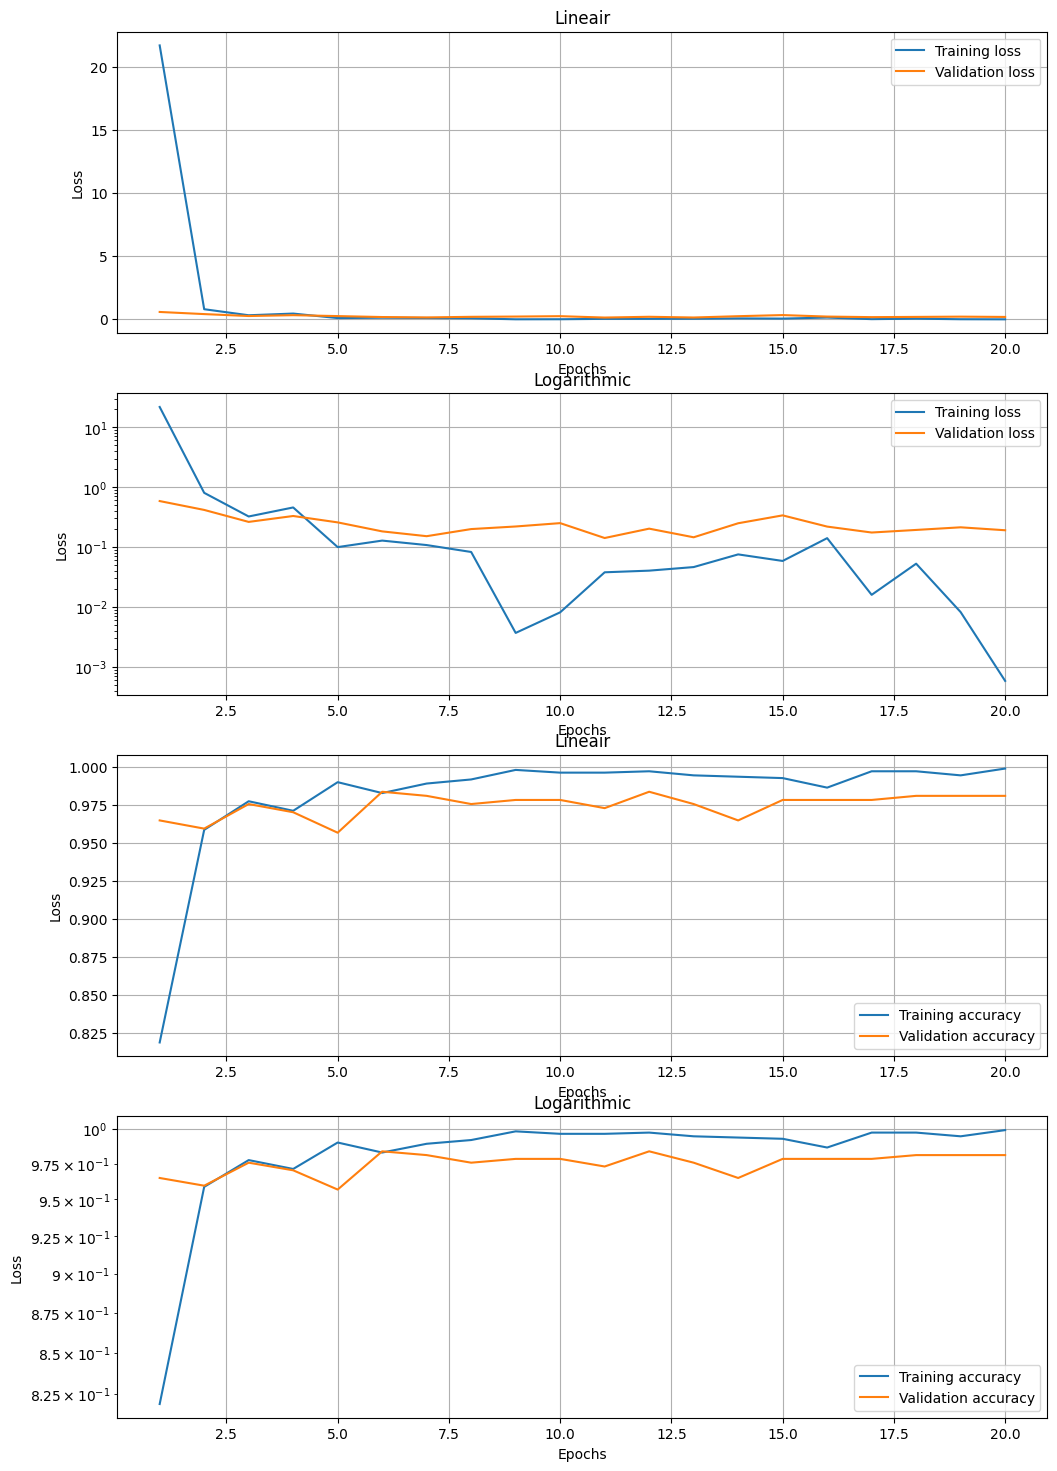

In [46]:
plot_loss(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
              precision    recall  f1-score   support

           0       0.98      0.83      0.90        66
           1       0.97      1.00      0.98       305

    accuracy                           0.97       371
   macro avg       0.97      0.92      0.94       371
weighted avg       0.97      0.97      0.97       371



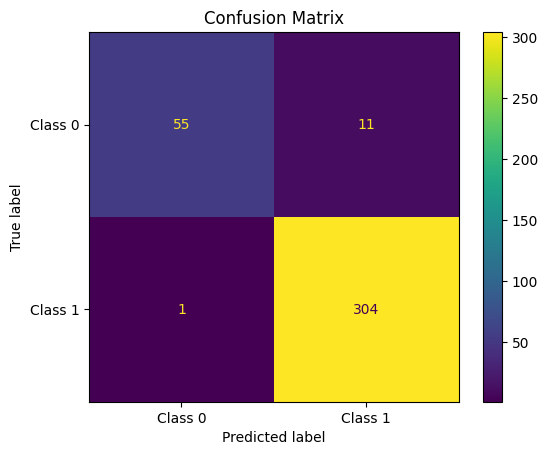

In [48]:
print_classification_report_and_confusion_matrix(model, test_features, test_labels)

### Xception with data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])

input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)